In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lib.fit_model_on_multiple import fit_lr, predict_lr, fit_rf, plot_md_vs_rmsd, predict_rf
from pathlib import Path
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from scipy.stats import linregress

In [59]:
length = 800
mds = []
rmsds = []

da = DihedralAdherence(
    'T1024', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
    weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda'
)
da.load_results_da()
da.grouped_preds_da['rmsd'] = da.grouped_preds.set_index('protein_id')['RMS_CA']
rmsd = da.grouped_preds_da['rmsd']
md = da.grouped_preds_da.iloc[:,:-1].values
if md.shape[1] < length:
    md = np.concatenate([md, np.zeros((md.shape[0], length-md.shape[1]))], axis=1)
if md.shape[1] > length:
    md = md[:,:length]

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
(484, 800)


In [67]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
# proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
proteins = ['T1024', 'T1027', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
preds = []
for protein in proteins:
    length = 1000
    da = DihedralAdherence(
        protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
        weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda'
    )
    da.load_results_da()
    da.filter_nas(.8)
    preds.append(da.grouped_preds)

preds = pd.concat(preds)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
No AlphaFold prediction found for 6yj1
No AlphaFold phi-psi data found
Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 

Slope: -0.48818046466502085, Intercept: 67.54497187897142


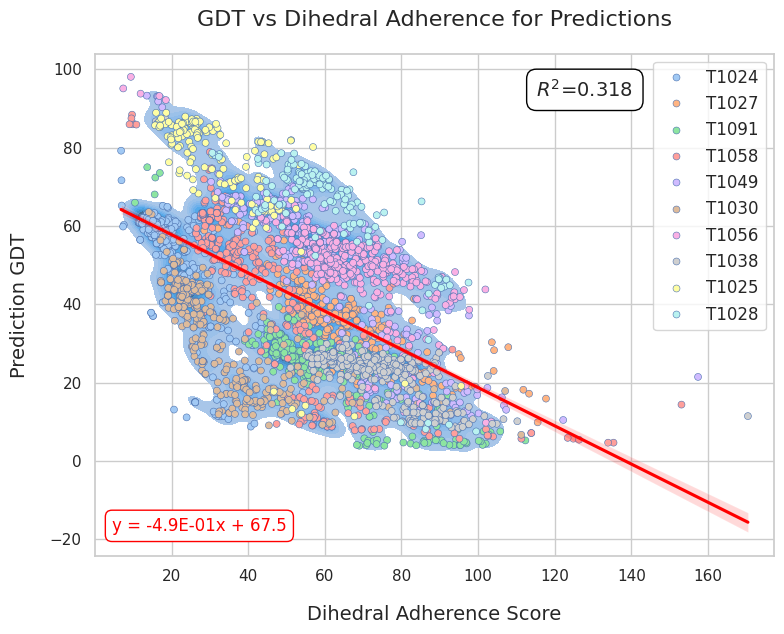

In [68]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
df = preds.dropna(subset=['da', 'GDT_TS']).reset_index(drop=True)
# df = df[df.GDT_TS < 20]
regr = linregress(df.da, df.GDT_TS)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
sns.kdeplot(data=df, x='da', y='GDT_TS', ax=ax, fill=True, bw_method=0.1)
sns.scatterplot(data=df, x='da', y='GDT_TS', ax=ax, marker='o', s=25, edgecolor='b', legend=True, hue='target')
sns.regplot(data=df.reset_index(drop=True), x='da', y='GDT_TS', ax=ax, scatter=False, color='red')
# ax.plot(
#     np.linspace(0, preds.da.max() + 5, 100), 
#     regr.intercept + regr.slope * np.linspace(0, preds.da.max() + 5, 100), 
#     color='red', lw=2, label='Regression Line'
# )

ax.set_xlabel('Dihedral Adherence Score', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction GDT', fontsize=14, labelpad=15)
ax.set_title(r'GDT vs Dihedral Adherence for Predictions', fontsize=16, pad=20)
ax.text(0.65, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
# ax.set_xlim(0, preds.da.max() + 5)
# ax.set_ylim(-0.5, preds.RMS_CA.max() + 5)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()

In [60]:
results = []
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')

    da.load_results_da()
    size1 = da.grouped_preds.shape[0]
    da.filter_nas(quantile=0.8)
    size2 = da.grouped_preds.shape[0]
    rsquared, pearsonr = da.test_correlation()
    results.append((protein, rsquared, pearsonr, size1-size2))
results = pd.DataFrame(results, columns=['protein', 'rsquared', 'pearsonr', 'lost'])
results.loc[len(results)] = ['Mean', results.rsquared.mean(), results.pearsonr.mean(), results.lost.mean()]
results.to_markdown('thisresult.md',index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
LinRegr - Slope: -1.077606701107049, Intercept: 74.92613741952442 R-squared: 0.5583641040196493 p-value: 1.1308926136830665e-70
Pearson Correlation: -0.7472376489575782, p-value: 1.1308926136833937e-70
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found
LinRegr - Slope: -0.4628887382374647, Intercept: 40.70884329909849 R-squared: 0.502869006902404 p-value: 6.4928530948950294e-55
Pearson Correlation: -0.7091325735730969, p-value: 6.492853094895757e-55
Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
LinRegr - Slope: -0.4876086844967219, Intercept: 66.05666265539526 R-squared: 0.5841942904875054 p-value: 3.951961357401346e-76
Pearson Correlation: -0.7643260367719428, p-value: 3.9519613574013623e-76
